## 0. Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 출력결과 모두 확인
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Data 

In [3]:
ai_detect_result = pd.read_excel('./data/탐지결과_2106-2108.xlsx')

In [4]:
len(ai_detect_result)

15153

# 2. Data 전처리 

*  ai 줄눈 탐지 데이터 

In [4]:
# 혹시 모를 사태를 대비해서 
ai_detect_result_copy = ai_detect_result.copy()

In [5]:
ai_detect_result.head(3)

# 주차는 엑셀로 작업함.

,탐지ID,탐지일시,주차,포트홀보수일시,본부,지사,노선,방향,이정,차로,위도,경도,줄눈상태
0,6202108310078,2021-08-31 16:05:44,5,NaN,광주전남본부,함평지사,서해안선,서울,30.39,2차로,35.068680,126.479530,정상
1,6202108310079,2021-08-31 16:05:44,5,NaN,광주전남본부,함평지사,서해안선,서울,30.39,2차로,35.068680,126.479530,정상
2,6202108310074,2021-08-31 16:04:58,5,NaN,광주전남본부,함평지사,서해안선,서울,29.10,2차로,35.057034,126.480766,정상


In [6]:
## 집계 함수 생성하기 

def make_chart(df,del_col,time_col,group_col):
    
    ## 필요없는 열 제거하기 
    temp_df  = df.drop(del_col,axis=1)
    
    ## 시계열 데이터로 변환 ( #월_#주 형식으로)
    temp_df['datetime'] = pd.to_datetime(temp_df[time_col])
    temp_df['month'] = temp_df['datetime'].dt.month # 월  표시
    temp_df['day'] =  temp_df['datetime'].dt.day # 요일  표시
    
    # 데이터 형 바꾸기 - int형에서 str 형으로 변환
    temp_df['주차']=temp_df.astype({'주차':'str'})['주차'] 
    temp_df['month']=temp_df.astype({'month':'str'})['month'] 
    
    temp_df['final_date'] = temp_df['month']+'월_' + temp_df['주차'] + '주' # 최종 변환 
    
    ## 줄눈 탐지 개수 집계하기
    julnun_count_col=group_col + ['final_date']
    julnun_count_group = temp_df.groupby(julnun_count_col) # groupby (기존 + final_date여야 함)
    julnun_count = julnun_count_group['탐지ID'].count()
    julnun_df = pd.DataFrame(julnun_count.reset_index())
    julnun_df.rename(columns={'탐지ID':'탐지개수'},inplace=True)
    
    ## 줄눈 탐지 일자 집계하기 
    julnun_day_count = julnun_count_group['day'].unique().reset_index()['day'].map(lambda x: len(x))
    julnun_df['탐지일수'] = julnun_day_count
    
    ## 정렬하기
    julnun_df = julnun_df.sort_values(by=julnun_count_col,
                                axis=0,
                                ascending=True) 
    
    ## 최종 데이터 셋 만들기 
    # column명 생성
    col_name_list1 = []
    col_name_list2 = []
    for month in range(6,9):
        for w_th in range(1,6):
            word1 = str(month)+'월_' + str(w_th)+'주_탐지개수'
            word2 = str(month)+'월_' + str(w_th)+'주_탐지일수'
            col_name_list1.append(word1)
            col_name_list2.append(word2)
            
    col_name_list = col_name_list1 + col_name_list2

    # 임시 형태 
    index = df.groupby(group_col)['탐지ID'].count().index # 각 그룹의 unique 값
    final_df = pd.DataFrame(np.zeros( (len(index),30) ,dtype='int64'),
                            index=index, columns= col_name_list)
    
    # 탐지 개수 and 탐지 일수 값 집어넣기  <- 최종set 생성
    for i in range(len(julnun_df)):
        if julnun_df['final_date'][i][0] == '6': 
            w_num= int(julnun_df['final_date'][i][3])-1
            idx = tuple(julnun_df[group_col].iloc[i,:])
            final_df.loc[idx][w_num]+= julnun_df['탐지개수'][i]
            final_df.loc[idx][w_num+15]+= julnun_df['탐지일수'][i]
        elif julnun_df['final_date'][i][0] == '7':             
            w_num= int(julnun_df['final_date'][i][3])-1
            idx = tuple(julnun_df[group_col].iloc[i,:])
            final_df.loc[idx][w_num+5]+= julnun_df['탐지개수'][i]
            final_df.loc[idx][w_num+5+15]+= julnun_df['탐지일수'][i]
            
        elif julnun_df['final_date'][i][0] == '8':           
            w_num= int(julnun_df['final_date'][i][3])-1
            idx = tuple(julnun_df[group_col].iloc[i,:])
            final_df.loc[idx][w_num+5+5]+= julnun_df['탐지개수'][i]
            final_df.loc[idx][w_num+5+5+15]+= julnun_df['탐지일수'][i]
    
    final_df= final_df.sort_index(ascending=True) 
    return julnun_df, final_df
    
    

In [7]:
# 함수 적용하기 
del_col = ['포트홀보수일시','줄눈상태']
time_col = '탐지일시'
group_col=['본부','지사','노선','방향']

julnun_df,final_df=make_chart(ai_detect_result,del_col=del_col,time_col=time_col,group_col=group_col)

In [15]:
final_df.to_csv("./final_data/ai_detect_본부지사노선방향.csv",encoding='cp949')

In [8]:
# 잘됐는지 확인하기 <- 잘됨
ai_detect_result[(ai_detect_result['본부']=='강원본부')&
                (ai_detect_result['지사']=='강릉지사')&
                (ai_detect_result['노선']=='동해선')&
                (ai_detect_result['방향']=='근덕')].head(4)
# 8월 _4주에 3건 있는데, 실제 데이터도 그렇게 나옴.

,탐지ID,탐지일시,주차,포트홀보수일시,본부,지사,노선,방향,이정,차로,위도,경도,줄눈상태
1336,37202108230013,2021-08-23 13:59:14,4,NaN,강원본부,강릉지사,동해선,근덕,88.86,2차로,37.992561,128.719406,정상
1337,37202108230012,2021-08-23 13:58:43,4,NaN,강원본부,강릉지사,동해선,근덕,89.72,2차로,37.999695,128.715561,정상
1338,37202108230011,2021-08-23 13:58:29,4,NaN,강원본부,강릉지사,동해선,근덕,90.10,2차로,38.003021,128.714478,정상
8994,37202107280006,2021-07-28 11:17:40,5,NaN,강원본부,강릉지사,동해선,근덕,51.88,2차로,37.699455,128.878647,정상


# 3. 집계표 생성

In [10]:

del_col = ['포트홀보수일시','줄눈상태']
time_col = '탐지일시'
group_col=['본부','지사']

원본_df,개수_df= make_chart(ai_detect_result,del_col=del_col,time_col=time_col,group_col=group_col)

In [13]:
개수_df.to_csv("./final_data/ai_detect_본부지사.csv",encoding='cp949')

* 본부지사_총 개수 및 일자에 대한 집계표 생성

In [11]:
# 데이터 새로 부르기
개수_df = pd.read_csv('./final_data/ai_detect_본부지사.csv',encoding='cp949',index_col=[0,1])

In [12]:
개수_df 

6월_1주_탐지개수  6월_2주_탐지개수  6월_3주_탐지개수  6월_4주_탐지개수  6월_5주_탐지개수  \
본부     지사                                                                   
강원본부   강릉지사             0           5           4           0          35   
       대관령지사            0           0           0           0           1   
       양양지사             0           0           0           0           0   
       원주지사             0           0           0          15          22   
       이천지사             0           0           0           0           0   
       춘천지사             0           0           0           0           2   
       홍천지사             0           0           0         104           0   
광주전남본부 광주지사             0           0           0           0           0   
       구례지사             0           0           0           0           0   
       남원지사             0           0           0           1           0   
       담양지사             0           0           0           0           0   
       보성지사             0           0           4           0           0   
       순천지사             0           0           2          24           0   
       함평지사             0           0          16          12          15   
대구경북본부 고령지사             0           0           0          23           9   
       구미지사             0           0           0         133           0   
       군위지사             0           3           0           3           0   
       대구지사             0           0           0           0           1   
       성주지사             0           0           0           0           0   
       영주지사             0           0           0           0           2   
       영천지사             0           1           1           0           0   
       청송지사             5           0           0          11           0   
대전충남본부 공주지사            22          95           0           0           0   
       당진지사             0         142           2         150           0   
       대전지사             0           1           3           0           0   
       부여지사             0           0           0           0           0   
       영동지사             0           9          27           0           8   
       천안지사             0           0           0           0           2   
부산경남본부 경주지사             0           0           0           0           0   
       고성지사             0           0          63           0           4   
       산청지사             0          21           0          52           0   
       서울산지사            0           0           0          16           0   
       양산지사             0           0           0           4           0   
       울산지사             0           0          53           0          31   
       진주지사             0           0           0           0          45   
       창녕지사             0          16           0           0           0   
       창원지사             0           0           0           6          27   
수도권본부  경기광주지사          19          29          40          26           2   
       군포지사             0           0           0           0           0   
       동서울지사            1           4           1           2           1   
       수원지사             0           3           1           0           0   
       시흥지사             0           0           0           0           0   
       인천지사             0           0           0           0           0   
       화성지사             0           0           0           0           0   
전북본부   논산지사             0           0           0           0          16   
       무주지사             0           0           0           0           0   
       보령지사             0           0           0         169           0   
       부안지사             0           0           0          29         174   
       전주지사             0           0           0           4           0   
       진안지사             0           0           0           0           0   
충북본부   보은지사

In [13]:
# 보고자료 만들기

개수_df['탐지개수'] = 개수_df.iloc[:,0:15].sum(axis=1).values
개수_df['탐지일수'] = 개수_df.iloc[:,15:30].sum(axis=1).values

# 총 탐지 개수 count 한거만 모으기 
총개수_df = 개수_df[['탐지개수','탐지일수']].reset_index()

# 누적 탐지 개수 구하기 
누적탐지개수 = pd.DataFrame(총개수_df .groupby(['본부'])['탐지개수'].sum().reset_index())
누적탐지일수 = pd.DataFrame(총개수_df .groupby(['본부'])['탐지일수'].sum().reset_index())

# column 이름 바꾸기
누적탐지개수.rename(columns={'탐지개수':'누적탐지개수'},inplace=True)
누적탐지일수.rename(columns={'탐지일수':'누적탐지일수'},inplace=True)

# 기존 데이터랑 join 하기
누적_df=pd.merge(누적탐지개수,누적탐지일수,on='본부',how='left')
총개수_df.set_index(['본부','지사'],inplace=True)
누적_df.set_index('본부',inplace=True)

In [14]:
총개수_df.head(3)
누적_df.head(3)

탐지개수  탐지일수
본부   지사               
강원본부 강릉지사     58     5
     대관령지사     7     5
     양양지사     14     4

,누적탐지개수,누적탐지일수
본부,,
강원본부,1847,45
광주전남본부,407,39
대구경북본부,759,69


In [482]:
len(총개수_df.index)/56*100

98.21428571428571

In [15]:
총개수_df.to_csv('./final_data/본부_지사_총개수_df.csv',encoding='cp949')
누적_df.to_csv('./final_data/본부_지사_누적개수_df.csv',encoding='cp949')

* 일자별 결과 

In [16]:
def make_day_chart(df,time_col,duplicate_col):
    
    ## 시계열 데이터로 변환 ( #월_#주 형식으로)
    df[time_col] = pd.to_datetime(df[time_col])
    df['일자'] = df[time_col].map(lambda x: x.strftime("%m-%d"))
    
    col_list = duplicate_col +['일자']
    final_df=df.drop_duplicates(col_list)
    return final_df

In [17]:
duplicate_col = ['본부','지사','노선','방향']
date_df = make_day_chart(df=ai_detect_result,time_col='탐지일시',duplicate_col=duplicate_col)
date_df=date_df.astype({'탐지일시':'object','일자':'object'})

In [479]:
date_df.to_csv('./final_data/일자별_df.csv',encoding='cp949')

## 4. EDA

* 지역별 탐지 현황

In [18]:
총개수_df['하루_탐지개수'] = 총개수_df['탐지개수'] / 총개수_df['탐지일수']

<Figure size 864x576 with 0 Axes>

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x1d1533def40>,
 [Text(0, 0, "('대전충남본부', '공주지사')"),
  Text(0, 1, "('전북본부', '무주지사')"),
  Text(0, 2, "('전북본부', '논산지사')"),
  Text(0, 3, "('부산경남본부', '산청지사')"),
  Text(0, 4, "('충북본부', '상주지사')"),
  Text(0, 5, "('대구경북본부', '구미지사')"),
  Text(0, 6, "('대전충남본부', '당진지사')"),
  Text(0, 7, "('전북본부', '부안지사')"),
  Text(0, 8, "('강원본부', '홍천지사')"),
  Text(0, 9, "('전북본부', '보령지사')")])

Text(0, 0.5, '관리기관')

Text(0.5, 0, '하루 평균 줄눈 탐지개수')

Text(0.5, 1.0, '상위 10개 지사의 하루 평균 줄눈 탐지개수')

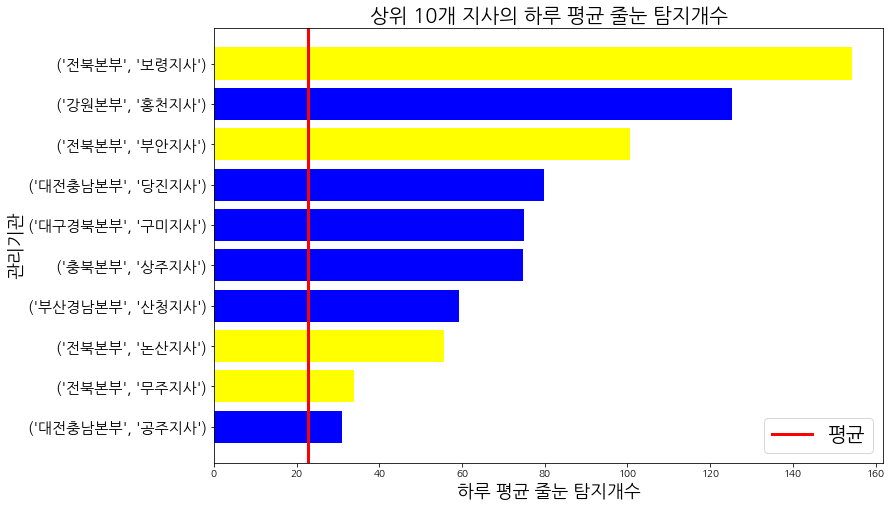

In [19]:
## 시각화 1 - 막대그래프
color_list=['blue','yellow','yellow','blue','blue','blue','blue','yellow','blue','yellow']

plt.rcParams['font.family'] ='NanumGothic'

index = np.arange(10)
plt.figure(figsize=(12,8))

# 통계량 나타내는 직선
plt.axvline(x= 총개수_df['하루_탐지개수'].describe()['mean'], color = 'r',label='평균',linewidth=3.0)

# 막대그림
plt.barh(index, 총개수_df['하루_탐지개수'].sort_values(ascending=True).tail(10),color=color_list)
plt.yticks(index,총개수_df['하루_탐지개수'].sort_values(ascending=True).tail(10).index, fontsize=15)
plt.ylabel('관리기관', fontsize=18)
plt.xlabel('하루 평균 줄눈 탐지개수', fontsize=18)

plt.title('상위 10개 지사의 하루 평균 줄눈 탐지개수', fontsize=20)  
plt.legend(fontsize=20)
plt.show()

<Figure size 864x576 with 0 Axes>

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x1ae6fb2aa90>,
 [Text(0, 0, "('수도권본부', '인천지사')"),
  Text(0, 1, "('광주전남본부', '남원지사')"),
  Text(0, 2, "('광주전남본부', '담양지사')"),
  Text(0, 3, "('강원본부', '대관령지사')"),
  Text(0, 4, "('대전충남본부', '천안지사')"),
  Text(0, 5, "('대구경북본부', '영천지사')"),
  Text(0, 6, "('대전충남본부', '대전지사')"),
  Text(0, 7, "('수도권본부', '수원지사')"),
  Text(0, 8, "('대구경북본부', '대구지사')"),
  Text(0, 9, "('대구경북본부', '영주지사')")])

Text(0, 0.5, '관리기관')

Text(0.5, 0, '하루 평균 줄눈 탐지개수')

Text(0.5, 1.0, '상위 10개 지사의 하루 평균 줄눈 탐지개수')

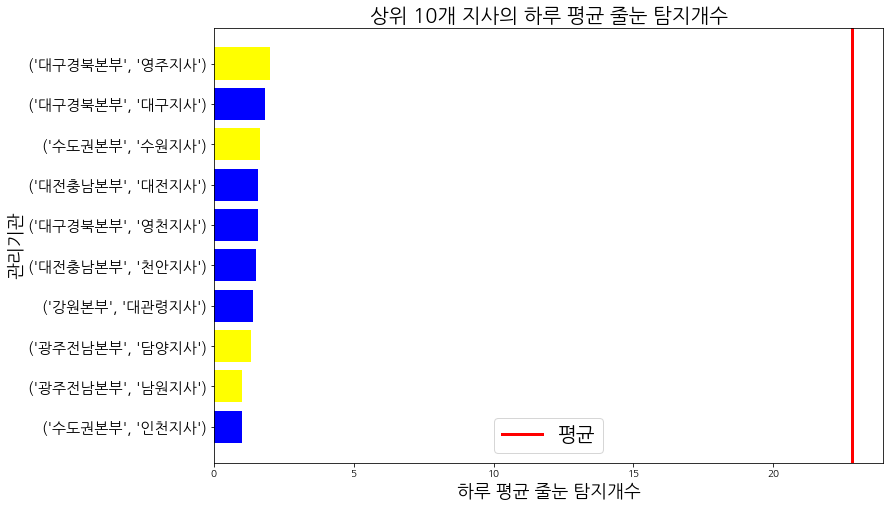

In [115]:
## 시각화 1 - 막대그래프
color_list=['blue','yellow','yellow','blue','blue','blue','blue','yellow','blue','yellow']

plt.rcParams['font.family'] ='NanumGothic'

index = np.arange(10)
plt.figure(figsize=(12,8))

# 통계량 나타내는 직선
plt.axvline(x= 총개수_df['하루_탐지개수'].describe()['mean'], color = 'r',label='평균',linewidth=3.0)

# 막대그림
plt.barh(index, 총개수_df['하루_탐지개수'].sort_values(ascending=True).head(10),color=color_list)
plt.yticks(index,총개수_df['하루_탐지개수'].sort_values(ascending=True).head(10).index, fontsize=15)
plt.ylabel('관리기관', fontsize=18)
plt.xlabel('하루 평균 줄눈 탐지개수', fontsize=18)

plt.title('상위 10개 지사의 하루 평균 줄눈 탐지개수', fontsize=20)  
plt.legend(fontsize=20)
plt.show()

* 본부별 통계량

In [24]:
총개수_df.reset_index().groupby(['본부'])['탐지개수'].sum() / 총개수_df.reset_index().groupby(['본부'])['탐지일수'].sum() # 본부별 하루 평균 탐지 개수
np.mean(총개수_df.reset_index().groupby(['본부'])['탐지개수'].sum() / 총개수_df.reset_index().groupby(['본부'])['탐지일수'].sum()) # 평균 

본부
강원본부      41.044444
광주전남본부    10.435897
대구경북본부    11.000000
대전충남본부    40.294872
부산경남본부    19.266667
수도권본부     10.986842
전북본부      61.098592
충북본부      24.781250
dtype: float64

27.36357049955491

 * 상위 1  - 전북본부

In [40]:
import seaborn as sns

In [116]:
mean = np.mean(총개수_df.reset_index().groupby(['본부'])['탐지개수'].sum() / 총개수_df.reset_index().groupby(['본부'])['탐지일수'].sum())

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:xlabel='지사', ylabel='하루_탐지개수'>

Text(0, 0.5, 'count')

Text(0.5, 0, '지사')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, '논산지사'),
  Text(1, 0, '무주지사'),
  Text(2, 0, '보령지사'),
  Text(3, 0, '부안지사'),
  Text(4, 0, '전주지사'),
  Text(5, 0, '진안지사'),
  Text(6, 0, '강릉지사'),
  Text(7, 0, '대관령지사'),
  Text(8, 0, '양양지사'),
  Text(9, 0, '원주지사'),
  Text(10, 0, '이천지사'),
  Text(11, 0, '춘천지사'),
  Text(12, 0, '홍천지사'),
  Text(13, 0, '공주지사'),
  Text(14, 0, '당진지사'),
  Text(15, 0, '대전지사'),
  Text(16, 0, '부여지사'),
  Text(17, 0, '영동지사'),
  Text(18, 0, '천안지사')])

([<matplotlib.axis.YTick at 0x1d162ac6820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Top 3 본부의 일일 평균 줄눈 탐지 현황')

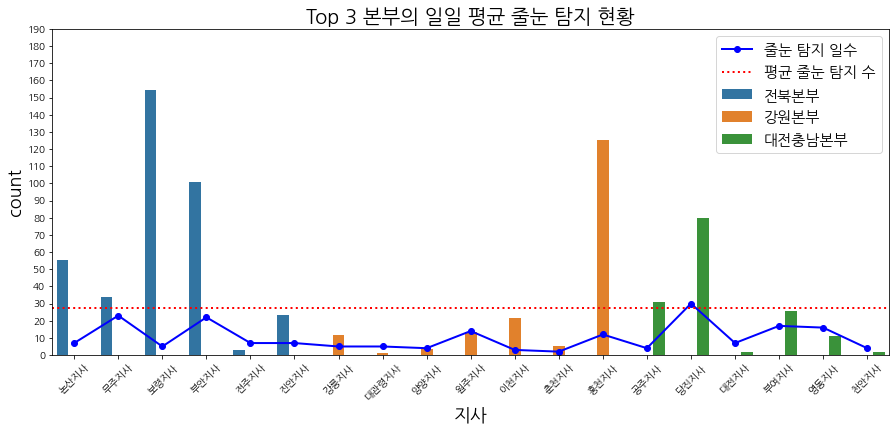

In [120]:
Top_본부_df = 총개수_df.loc[['전북본부','강원본부','대전충남본부']].reset_index().set_index(['지사'])

plt.rcParams['font.family'] ='NanumGothic'

index = np.arange(len(Top_본부_df))
plt.figure(figsize=(15,6))

# 탐지개수와 , 탐지일수 나타내기
#plt.plot(Top_본부_df[['탐지개수']],label= '줄눈 탐지 개수',color='red',linewidth=3.0)
plt.plot(Top_본부_df[['탐지일수']],color='blue',label= '줄눈 탐지 일수',linewidth=2,marker='o')

# 통계량 나타내는 직선
plt.axhline(y=mean,label= '평균 줄눈 탐지 수' ,color='r', linewidth=2,linestyle='dotted')

#막대그림

sns.barplot(
    data= Top_본부_df.reset_index(),
    x= "지사",
    y= "하루_탐지개수",
    hue = '본부',
)

plt.ylabel('count', fontsize=18)
plt.xlabel('지사',fontsize=18)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,200,10))

plt.title('Top 3 본부의 일일 평균 줄눈 탐지 현황', fontsize=20)  
plt.legend(fontsize=15)
plt.show()

<Figure size 1080x432 with 0 Axes>

<AxesSubplot:xlabel='지사', ylabel='하루_탐지개수'>

Text(0, 0.5, 'count')

Text(0.5, 0, '지사')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '광주지사'),
  Text(1, 0, '구례지사'),
  Text(2, 0, '남원지사'),
  Text(3, 0, '담양지사'),
  Text(4, 0, '보성지사'),
  Text(5, 0, '순천지사'),
  Text(6, 0, '함평지사'),
  Text(7, 0, '경기광주지사'),
  Text(8, 0, '군포지사'),
  Text(9, 0, '동서울지사'),
  Text(10, 0, '수원지사'),
  Text(11, 0, '시흥지사'),
  Text(12, 0, '인천지사'),
  Text(13, 0, '화성지사'),
  Text(14, 0, '고령지사'),
  Text(15, 0, '구미지사'),
  Text(16, 0, '군위지사'),
  Text(17, 0, '대구지사'),
  Text(18, 0, '성주지사'),
  Text(19, 0, '영주지사'),
  Text(20, 0, '영천지사'),
  Text(21, 0, '청송지사')])

([<matplotlib.axis.YTick at 0x1d162376e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Bottom 3 본부의 일일 평균 줄눈 탐지 현황')

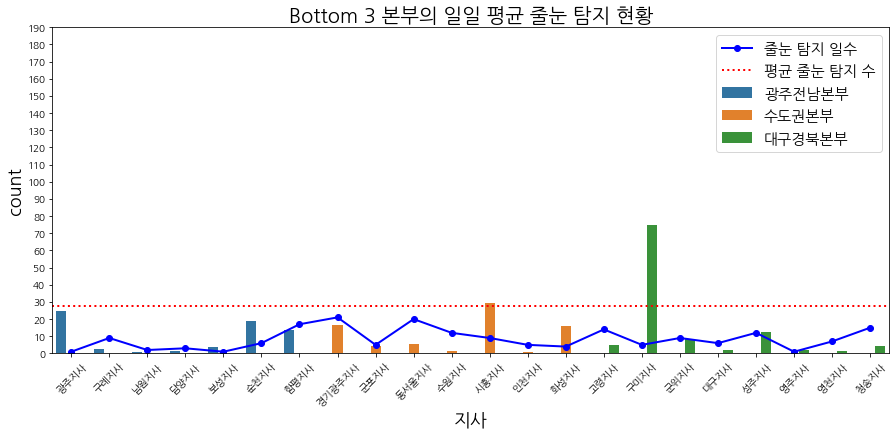

In [119]:
Bottom_본부_df = 총개수_df.loc[['광주전남본부','수도권본부','대구경북본부']].reset_index().set_index(['지사'])

plt.rcParams['font.family'] ='NanumGothic'

index = np.arange(len(Bottom_본부_df))
plt.figure(figsize=(15,6))

# 탐지개수와 , 탐지일수 나타내기
#plt.plot(Top_본부_df[['탐지개수']],label= '줄눈 탐지 개수',color='red',linewidth=3.0)
plt.plot(Bottom_본부_df[['탐지일수']],color='blue',label= '줄눈 탐지 일수',linewidth=2,marker='o')

# 통계량 나타내는 직선
plt.axhline(y=mean,label= '평균 줄눈 탐지 수' ,color='r', linewidth=2,linestyle='dotted')

#막대그림

sns.barplot(
    data= Bottom_본부_df.reset_index(),
    x= "지사",
    y= "하루_탐지개수",
    hue = '본부',
)

plt.ylabel('count', fontsize=18)
plt.xlabel('지사',fontsize=18)
plt.xticks(rotation=45)
plt.yticks(np.arange(0,200,10))

plt.title('Bottom 3 본부의 일일 평균 줄눈 탐지 현황', fontsize=20)  
plt.legend(fontsize=15)
plt.show()